<a href="https://colab.research.google.com/github/hughesymendes/TIC-27491137/blob/master/Detrending_Bugged_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lightkurve

!pip install exoplanet

!pip install pymc3==3.8

!pip install corner

/usr/local/lib/python3.6/dist-packages/lightkurve/lightcurve.py:694: LightkurveWarning: The light curve has a negative median flux (-6.85e+02); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  LightkurveWarning)
/usr/local/lib/python3.6/dist-packages/lightkurve/lightcurve.py:694: LightkurveWarning: The light curve has a negative median flux (-1.13e+03); `normalize()` will therefore divide by a negative number and invert the light curve, which is probablynot what you want
  LightkurveWarning)


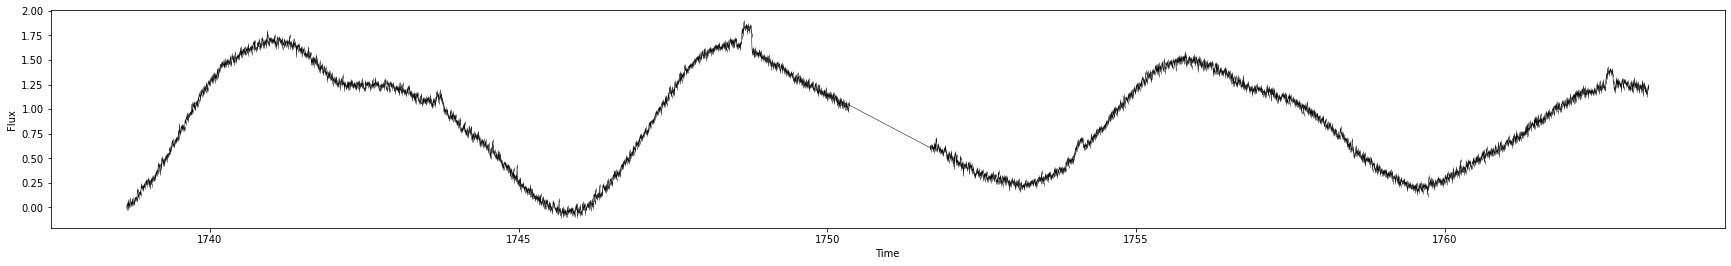

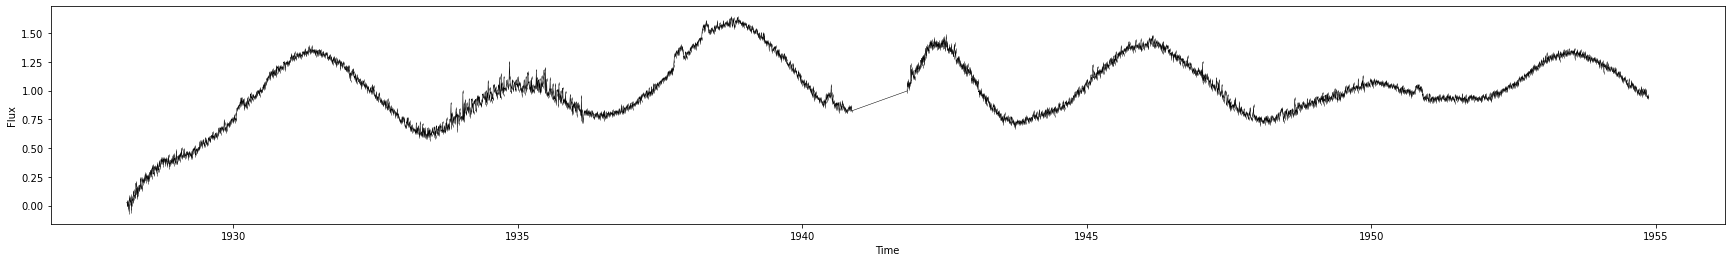

In [3]:
import lightkurve as lk
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
%matplotlib inline

flags = lk.utils.TessQualityFlags
q = flags.CoarsePoint | flags.Desat | flags.Argabrightening

tpfs = lk.search_targetpixelfile("TIC 27491137").download_all(quality_bitmask=q)

clcs = []
for tpf in tpfs:
    breaks = np.where(np.append(False, np.diff(tpf.time) > (np.median(np.diff(tpf.time)) * 5)))[0]
    aper = tpf.create_threshold_mask()


    lc = tpf.to_lightcurve()

    # Scattered light
    bkg = tpf.get_bkg_lightcurve(tpf.pipeline_mask)
    bkg[~np.isfinite(lc.flux_err)].flux *= 0
    lc += bkg
    lc.flux_err[~np.isfinite(lc.flux_err)] = np.nanmedian(lc.flux_err)

    bkg = tpf.flux_bkg
    bkg[~np.isfinite(bkg)] = 0
    pixels = (tpf.flux + bkg)[:, ~aper]
    dm1 = lk.DesignMatrix(pixels, name='pixels').pca(3).split(list(breaks)).append_constant()
    
    # centroids
    t = (lc.cadenceno - np.median(lc.cadenceno))/(len(lc.time))
    ts = np.vstack([((tpf.time - t[0])/(t[-1] - t[0]) - 0.5) * np.in1d(tpf.time, t) for t in np.array_split(tpf.time, [np.where(np.diff(tpf.time) > 0.5)[0][0] + 1])]).T
    p1 = np.vstack([np.nan_to_num(tpf.pos_corr1) * np.in1d(tpf.time, t)  for t in np.array_split(tpf.time, [np.where(np.diff(tpf.time) > 0.5)[0][0] + 1])]).T
    p2 = np.vstack([np.nan_to_num(tpf.pos_corr2) * np.in1d(tpf.time, t)  for t in np.array_split(tpf.time, [np.where(np.diff(tpf.time) > 0.5)[0][0] + 1])]).T
    pdm = lk.DesignMatrix(np.hstack([ts, ts**2, p1, p2, p1*p2, p1**2*p2, p1*p2**2, p1**2*p2**2]), name = 'poscorrs')
    pdm.prior_sigma = np.ones(pdm.shape[1]) * 0.01

    
    spline = lk.designmatrix.create_spline_matrix(lc.time, n_knots=80)

    dm = lk.DesignMatrixCollection([dm1, pdm, spline])

    # First iteration
    r = lk.RegressionCorrector(lc)
    clean_lc = r.correct(dm, sigma=1e10)

    # YOU SHOULD REPLACE THIS HACKY MASK WITH A BETTER ONE.
    a = (clean_lc).bin(10).flatten(81)
    _, m = a.remove_outliers(2, return_mask=True)
    m = (convolve(m, Box1DKernel(10)) > 0.5)
    mask = np.interp(clean_lc.time, a.time, m) > 0
    mask = convolve(mask, Box1DKernel(5)) > 0

    # second iteration
    r = lk.RegressionCorrector(lc)
    _ = r.correct(dm, sigma=1e10)
    corr = (r.diagnostic_lightcurves['poscorrs'] + r.diagnostic_lightcurves['pixels'])
    clean_lc = (lc - corr).normalize()

    clean_lc = lk.LightCurve(np.asarray(clean_lc.time, np.float64),
                         np.asarray(clean_lc.flux, np.float64),
                         np.asarray(clean_lc.flux_err, np.float64))

    fig, ax = plt.subplots(figsize=(30, 4))
    (clean_lc).bin(5, method='median').errorbar(ls='-', ax=ax, c='k')
    
    clcs.append(clean_lc.normalize())